In [ ]:
# This program was written to compare three different docking protocols for heparan sulfate oligosaccharides.

# Rigid: glycosidic linkages have no flexibility and are restricted to the crystal structure values.
# Semi-rigid: glycosidic linkages can explore + or - 30 degrees in phi and psi.
# Flexible: free rotation of glycosidic linkages.

# The top 6 scoring poses for all three protocols are plotted on one ramachandran plot for a specific linkage, starting 
# at the reducing end of the polymer. The purple box in the plot indicates the semi-rigid boundaries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
def calc_TA(atom_set):
    """This function calculates a torsional angle, given the four atoms of interest in the correct order from a mol2.
        The atom set should be a nested list, with each element of the list being one of the four atom lines, split by white
        space."""
    # Isolate the coordinates for each atom and save them to a variable
    i = atom_set[0][2:5]
    j = atom_set[1][2:5]
    k = atom_set[2][2:5]
    l = atom_set[3][2:5]
    
    # Calculate vectors r_ij, r_jk, and r_kl
    r_ij = []
    r_ij.append((float(j[0]) - float(i[0])))
    r_ij.append((float(j[1]) - float(i[1])))
    r_ij.append((float(j[2]) - float(i[2])))

    r_jk = []
    r_jk.append((float(k[0]) - float(j[0])))
    r_jk.append((float(k[1]) - float(j[1])))
    r_jk.append((float(k[2]) - float(j[2])))

    r_kl = []
    r_kl.append((float(l[0]) - float(k[0])))
    r_kl.append((float(l[1]) - float(k[1])))
    r_kl.append((float(l[2]) - float(k[2])))

    # calculate the normal vectors to the planes formed by atoms ijk and jkl
    import numpy as np
    n_ijk = np.cross(r_ij, r_jk)
    n_jkl = np.cross(r_jk, r_kl)
    
    # calculate the dot product of n_ijk and n_jkl
    dot = np.dot(n_ijk, n_jkl)

    # calculate the magnitudes of n_ijk and n_jkl
    mag_n_ijk = (n_ijk[0]**2 + n_ijk[1]**2 + n_ijk[2]**2)**(1/2)
    mag_n_jkl = (n_jkl[0]**2 + n_jkl[1]**2 + n_jkl[2]**2)**(1/2)

    # calculate the torsional angle 
    TA = np.arccos(dot/(mag_n_ijk * mag_n_jkl))
    TA = np.degrees(TA)
    
    # This calculation will always be positive (0 to 180), but TA in molecules are defined from -180 to 180 to indicate 
    # direction of the angle (cw or ccw). I don't know why, but this correctly changes the sign. Found it online somewhere....
    sign = np.dot(n_ijk, r_kl)
    if sign > 0:
        return round(TA, 1)
    else:
        return round(-TA, 1)
    




In [3]:
def get_residues(solution):
    """This function returns a list with two elements containing the NRE residue number and the RE residue number
            which will always be 1"""
    with open(solution) as f:
        lines = f.readlines()

    red = '1'
    for line in lines:
        if '@<TRIPOS>BOND' in line:
            break
        elif len(line.split()) == 9:
            nr = line.split()[6]

    return [red, nr]


In [4]:
def get_phi_psi_atoms(solution, nr_res, red_res):
    """This function takes a mol2, and the number of the non-reducing residue and reducing residue defining the linkage 
        where the user wants the specific phi and psi atoms involved."""
    with open(solution) as f:
        lines = f.readlines()

    for line in lines:
        if len(line.split()) == 9:
            if 'O5' in line and 'O.3' in line and line.split()[6] == nr_res:
                O5 = line.split()
            if 'C1' in line and 'C.3' in line and line.split()[6] == nr_res:
                C1 = line.split()
            if 'O4' in line and 'O.3' in line and line.split()[6] == red_res:
                O4 = line.split()
            if 'C4' in line and 'C.3' in line and line.split()[6] == red_res:
                C4 = line.split()
            if 'C5' in line and 'C.3' in line and line.split()[6] == red_res:
                C5 = line.split()

    phi_atoms = [O5, C1, O4, C4]
    psi_atoms = [C1, O4, C4, C5]  

    return phi_atoms, psi_atoms

In [5]:
# Use the first solution in the rigid directory so you can quickly determine the RE and NRE residue numbers. 
os.chdir(f'C:/Users/samho/Documents/Semi-Rigid Docking Protocol/using_crystal_structure_values/100_GA/1E0O/rigid')
solutions = [] 
all_files = os.listdir()

for file in all_files:
    if 'gold' in file:
        solutions.append(file)

sol_res = get_residues(solutions[0])
print(sol_res)

# Save the rigid phi and psi values using any rigid pose since they are used to define the semi-rigid boundaries.
df = pd.DataFrame()
nre = int(sol_res[1])
while nre != 1:
    phi_atoms, psi_atoms = get_phi_psi_atoms(solutions[0], str(nre), str(nre - 1))
    df = df.append({f'Phi {nre} to {nre - 1}' : calc_TA(phi_atoms)}, ignore_index = True)
    df = df.append({f'Psi {nre} to {nre - 1}' : calc_TA(psi_atoms)}, ignore_index = True)
    nre = nre - 1
    
# Get a list of just the column headers
headers = df.columns.values.tolist()

# Now create a datframe where you have removed NaN
native = pd.DataFrame()

for header in headers:
    no_nan = df[header].dropna()
    no_nan = no_nan.reset_index()
    native = pd.concat([native, no_nan], axis = 1)
    native = native.drop(columns = 'index')

print(native)

['1', '10']
   Phi 10 to 9  Psi 10 to 9  Phi 9 to 8  Psi 9 to 8  Phi 8 to 7  Psi 8 to 7  \
0       -106.1       -131.0       134.7      -151.1       -64.9      -116.5   

   Phi 7 to 6  Psi 7 to 6  Phi 6 to 5  Psi 6 to 5  Phi 5 to 4  Psi 5 to 4  \
0       117.6      -134.8       -76.3      -103.2       141.4      -142.8   

   Phi 4 to 3  Psi 4 to 3  Phi 3 to 2  Psi 3 to 2  Phi 2 to 1  Psi 2 to 1  
0       -62.1      -164.8        78.6      -140.4       -79.6      -107.6  


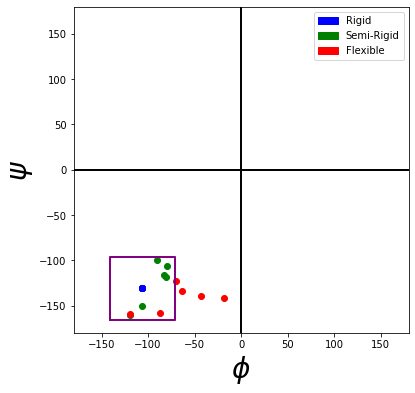

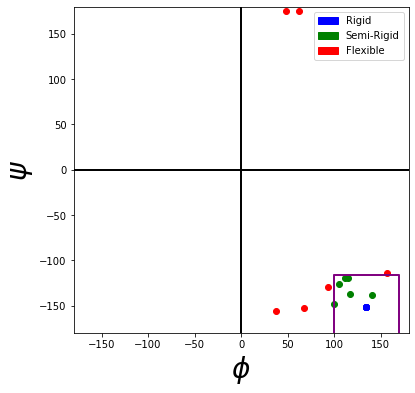

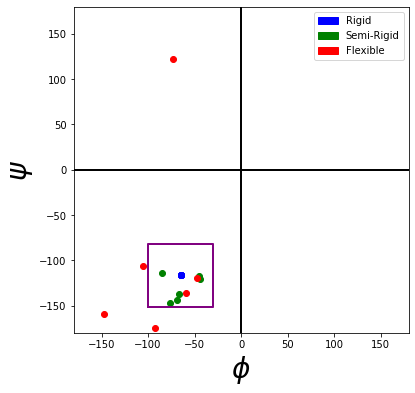

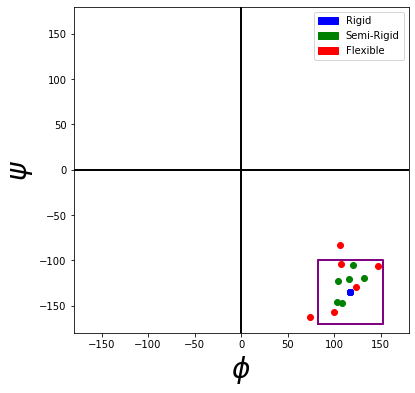

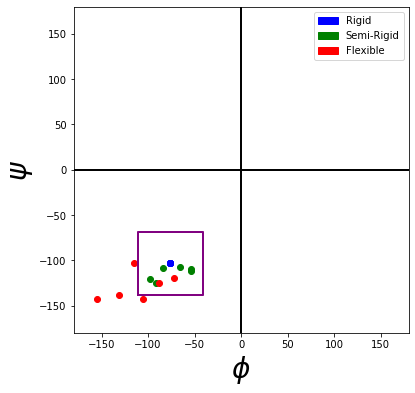

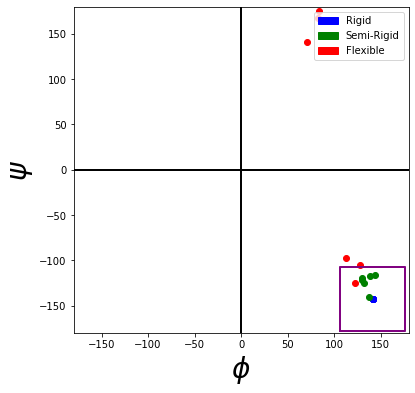

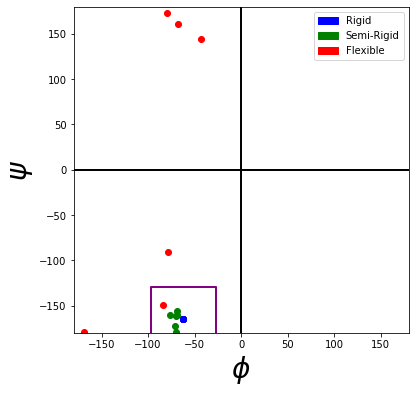

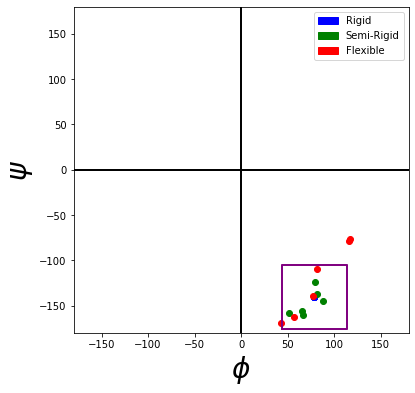

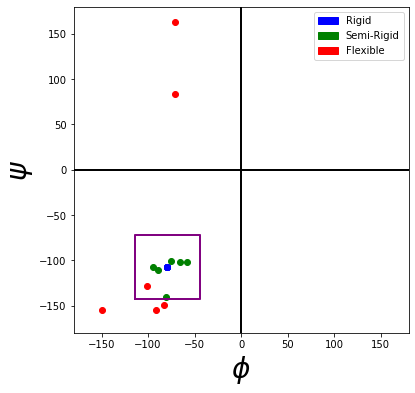

In [6]:
# I am now changing the order of the program compared to previous versions. Instead, I will now calculate phi and psi for
# the 8 to 7 linkage starting with rigid, then on to semi-rigid, then on to flexible. ONLY THEN do you move to the next 
# linkage. This way, all three can be plotted on the same figure, which is only for one linkage. 

nre = int(sol_res[1])
while nre != 1:
    protocols = ['rigid', 'semi-rigid', 'flexible']
    colors = ['blue', 'green', 'red']
    
    # Set up the figure
    fig, ax = plt.subplots()

    fig.set_figwidth(6)
    fig.set_figheight(6)

    for protocol, color in zip(protocols, colors):

        # Create a dataframe with two columns, phi and psi for this linkage
        df = pd.DataFrame()

        df[f'Phi {nre} to {nre - 1}'] = []
        df[f'Psi {nre} to {nre - 1}'] = []
            

        os.chdir(f'C:/Users/samho/Documents/Semi-Rigid Docking Protocol/using_crystal_structure_values/100_GA/1E0O/{protocol}')
        all_files = os.listdir()

        solutions = []
        for file in all_files:
            if 'gold' in file:
                solutions.append(file)

        for solution in solutions:
            phi_atoms, psi_atoms = get_phi_psi_atoms(solution, str(nre), str(nre - 1))
            df = df.append({f'Phi {nre} to {nre - 1}' : calc_TA(phi_atoms)}, ignore_index = True)
            df = df.append({f'Psi {nre} to {nre - 1}' : calc_TA(psi_atoms)}, ignore_index = True)


        # This is almost what you want, but you need to drop all the NaN values so the columns are shortened to just the 6
        # values.

        # Get a list of just the column headers
        headers = df.columns.values.tolist()

        # Now create a datframe where you have removed NaN
        short_df = pd.DataFrame()

        for header in headers:
            no_nan = df[header].dropna()
            no_nan = no_nan.reset_index()
            short_df = pd.concat([short_df, no_nan], axis = 1)
            short_df = short_df.drop(columns = 'index')
        
        # AT THIS POINT, YOU HAVE A DATAFRAME WITH PHI AND PSI OF ALL 6 SOLUTIONS FOR THE CURRENT LINKAGE AND CURRENT PROTOCOL
        
        
        # Plot phi and psi
        plt.scatter(short_df[f'Phi {nre} to {nre - 1}'], short_df[f'Psi {nre} to {nre - 1}'], c = color)
        plt.xlim(-180,180)
        plt.ylim((-180,180)) 
        
        #Here's the syntax for inserting greek letters into axis labels!
        plt.xlabel(r'$\phi$', fontsize = 28)
        plt.ylabel(r'$\psi$', fontsize = 28)



        # Now plot the square representing the semi-rigid boundary. Use the native phi and psi that you saved as a list
        # above to calculate the points of the square. 
        lower_left = [native[f'Phi {nre} to {nre - 1}'].iloc[0] - 35, native[f'Psi {nre} to {nre - 1}'].iloc[0] - 35]
        lower_right = [native[f'Phi {nre} to {nre - 1}'].iloc[0] + 35, native[f'Psi {nre} to {nre - 1}'].iloc[0] - 35]
        upper_right = [native[f'Phi {nre} to {nre - 1}'].iloc[0] + 35, native[f'Psi {nre} to {nre - 1}'].iloc[0] + 35]
        upper_left = [native[f'Phi {nre} to {nre - 1}'].iloc[0] - 35, native[f'Psi {nre} to {nre - 1}'].iloc[0] + 35]

        square = [lower_left, lower_right, upper_right, upper_left, lower_left]
        square = np.array(square)
        square = np.transpose(square)

        plt.plot(square[0], square[1], c = 'purple')
        
        # Plot lines to show vertical and horizontal axes.
        plt.axhline(c = 'black')
        plt.axvline(c = 'black')
        
        #Legend
        import matplotlib.patches as mpatches
        blue_patch = mpatches.Patch(color='blue', label='Rigid')
        green_patch = mpatches.Patch(color='green', label='Semi-Rigid')
        red_patch = mpatches.Patch(color = 'red', label = 'Flexible')
        
        plt.legend(handles=[blue_patch, green_patch, red_patch], loc = 'upper right')
                                     
        # Save the figure                           
        plt.savefig(f'C:/Users/samho/Documents/Semi-Rigid Docking Protocol/using_crystal_structure_values/100_GA/1E0O/{nre}to{nre-1}.png', bbox_inches='tight')
        
        
    nre = nre-1
        
        
       